## Importing the data

https://www.kaggle.com/code/amyjang/tensorflow-image-classification-with-malaria-tfds/notebook

In [33]:
import tensorflow_datasets.public_api as tfds
import tensorflow as tf

In [30]:
ds, info = tfds.load('malaria', split='train', shuffle_files=True, with_info=True)

In [27]:
print("Num classes: " + str(info.features['label'].num_classes))
print("Class names: " + str(info.features['label'].names))

Num classes: 2
Class names: ['parasitized', 'uninfected']


## Visualizing the data

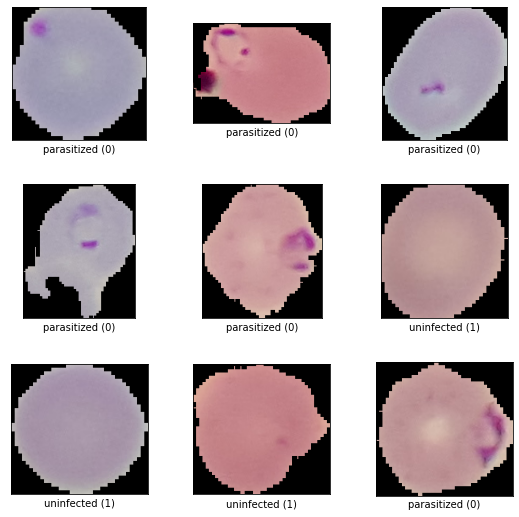

In [28]:
vis = tfds.visualization.show_examples(ds, info)

# Load Splitted data directly

In [31]:
BATCH_SIZE = 32
IMAGE_SIZE = [200, 200]

train_ds, val_ds, test_ds = tfds.load('malaria',
                                      split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                      shuffle_files=True, as_supervised=True)

In [34]:
NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(train_ds).numpy()
print("Num training images: " + str(NUM_TRAIN_IMAGES))

NUM_VAL_IMAGES = tf.data.experimental.cardinality(val_ds).numpy()
print("Num validating images: " + str(NUM_VAL_IMAGES))

NUM_TEST_IMAGES = tf.data.experimental.cardinality(test_ds).numpy()
print("Num testing images: " + str(NUM_TEST_IMAGES))

Num training images: 19291
Num validating images: 4133
Num testing images: 4134


### Reshape the input

In [36]:
# Check random image size
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (103, 103, 3)
Label:  1


Note:  Not all the images are of size (200, 200). Thankfully, TensorFlow Image API has a way to resize images by either cropping big pictures or padding smaller ones. Let's define our padding method.

In [37]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

def pad(image,label):
  image,label = convert(image, label)
  image = tf.image.resize_with_crop_or_pad(image, 200, 200)
  return image,label

**Note :** We have to use .map() to apply our padding method to all of our images. While we are at it, we should batch our images.

In [38]:
padded_train_ds = (
    train_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

padded_val_ds = (
    val_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

In [41]:
# Visualize
import matplotlib.pyplot as plt

image_batch, label_batch = next(iter(padded_train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("uninfected")
        else:
            plt.title("parasitized")
        plt.axis("off")

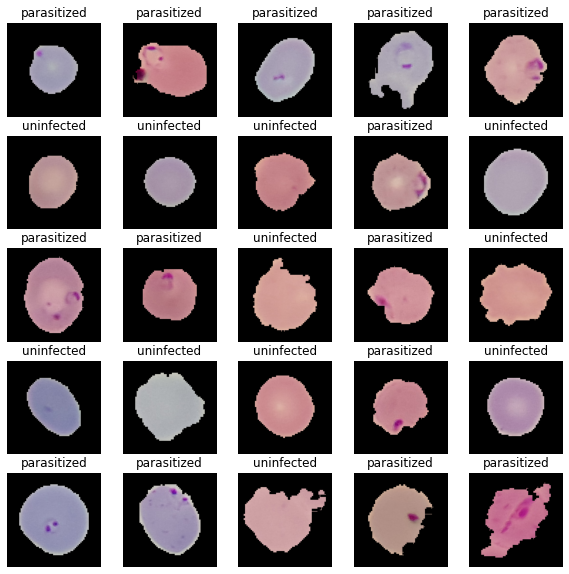

In [42]:
show_batch(image_batch,label_batch)

In [44]:
len(padded_train_ds) , len(padded_val_ds)

(603, 130)

In [49]:
padded_train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Model 1: Baseline model

In [51]:
# Set random seed
tf.random.set_seed(42)

# Build a CNN model (same as the Tiny VGG on the CNN explainer website)
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation='relu',
                           input_shape=(200,200,3)),

    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding='valid'),
                               
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

# Compile the Model
model_1.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

#Fir the model
history_1 = model_1.fit(padded_train_ds,
                        epochs=5,
                        steps_per_epoch=len(padded_train_ds),
                        validation_data=padded_val_ds,
                        validation_steps=len(padded_val_ds))

Epoch 1/5
603/603 [==============================] - 1285s 2s/step - loss: 0.6137 - accuracy: 0.6673 - val_loss: 0.4082 - val_accuracy: 0.8708
Epoch 2/5
603/603 [==============================] - 1237s 2s/step - loss: 0.4035 - accuracy: 0.8507 - val_loss: 0.3440 - val_accuracy: 0.8843
Epoch 3/5
603/603 [==============================] - 1248s 2s/step - loss: 0.3169 - accuracy: 0.8904 - val_loss: 0.3063 - val_accuracy: 0.8926
Epoch 4/5
603/603 [==============================] - 1235s 2s/step - loss: 0.2388 - accuracy: 0.9186 - val_loss: 0.2257 - val_accuracy: 0.9264
Epoch 5/5
603/603 [==============================] - 1203s 2s/step - loss: 0.1725 - accuracy: 0.9407 - val_loss: 0.1937 - val_accuracy: 0.9323
